# Introduction

The Wisconsin Card Sorting Test is a task designed to analyze individuals cognitive ability, planning, generalization ability, and decision making. In analyses on monkeys and humans performing a variation of the task (publication soon!), monkeys perform the task with a reinforcement learning framework while humans perform like a memory-limited optimal agent.

With this in mind, how does a reinforcement learning (RL) agent solve this task?\
How well can an RL agent perform?\
And what insights can be found about real subject performance given the RL performance?

There are many ways to implement RL agents to solve this task. I begin with the most naive approach and gradually build complexity. By the end, I implement a Recurrent Neural Network (RNN), which directly learns the task structure.

### Task Design

Four cards appear on the screen, each with a unique color, shape, and pattern:

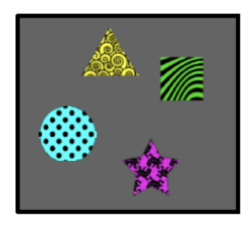

In [1]:
from matplotlib import image as mpimg
import matplotlib.pyplot as plt

image = mpimg.imread("Figures/wcst_image1.png")
fig, ax = plt.subplots(1,1)
ax.imshow(image)
_ = ax.axis("off")

One of the 12 features (4 colors, 4 shapes, 4 patterns) is the "rule," and the subject is rewarded if that feature is chosen. After selecting a card and receiving feedback, a new trial begins with randomly shuffled features.

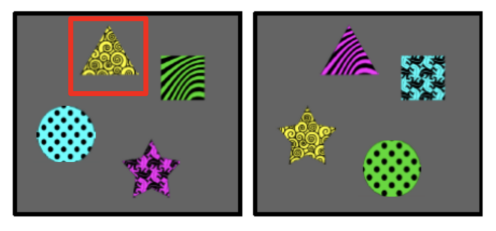

In [2]:
image = mpimg.imread("Figures/wcst_image2.png")
fig, ax = plt.subplots(1,1, figsize=(14,4))
ax.imshow(image)
_ = ax.axis("off")

The red border indicates an incorrect choice.

After some number of correct trials in a row, the rule spontaneously changes. Then, the agent needs to relearn and find the new rule.

I will consider two general cases:
1. No rule change. This is a control for when the subject learns slowly.
2. The exact criterion that is used for the monkeys: the rule changes after 8 out of 8 or 16 out of 20 correct trials in a row

### Task Complexity

There are three aspects that make this task interesting:
1. Credit assignment: By choosing one card, one simultaneously chooses 3 features. Some strategy is needed to identify the singular correct feature.
2. Dimensionality: Given 12 features, there are 4^3 or 64 possible cards that can be seen. Further, if one considers every organization of cards as an independent state, there are ~10000 different states.
3. Non-stationarity: The rule is constantly changing, so the agent needs to constantly adapt and relearn. Ideally, the agent will learn this non-stationarity such that internal weights do not need to be constantly adjusted.

### Baseline Performance (Random vs Optimal)

Agent performances are compared to two baseline performances:
1. A purely random agent (selects one of four cards at random), which is correct about 25% of the time
2. An "optimal" agent, which maximizes the probability of choosing the correct feature using logic (note that it does not "know" anything about the rule changing). When the rule does not change, the optimal agent is correct on every trial after the first few. When the rule changes, the optimal agent is correct 75 +/- 3% of the time (see "run_optimal_agent.ipynb" for details)

### Outline

I train different agents on the task to explore different behaviors. The end goal is to train an agent that meets the following criteria:
1. Internal weights do NOT update to continually solve the task.
2. The agent does NOT "know" any task structure. That is, the agent doesn't know that features are important or that the rule changes.

This way, we can understand what the agent learns about the task with minimal knowledge of how to act.

Towards this end, I develop RL agents in the following order, slowly building complexity:
1. Tabular based methods: The most naive approach.
2. Function approximation: Using neural networks to simplify the state space.
3. Recurrent Neural Networks: Using memory and learning to learn the non-stationarities.

# Imports

In [30]:
# Import necessary functions
import numpy as np
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from tools import *

# Import agents
from agents import *

# Gathers task environment
from WCST import WcstSession
num_cards = 4
num_dims = 3

# Tabular Based Methods

While the goal is to build up to an RNN agent, the simplest case is to build lookup table based on every state. Since the states are randomized after every trial, I'll use the Sarsa algorithm with lambda = gamma = 0 and alpha = 1. Choices are greedy.

The state space is comprised of every possible grouping of features and orders, which is 4! per dimension. The action space is comprised of the four possible actions. In total, there are 55296 state-action pairs!

To reduce the number of pairs, one can exploit the symmetry of the problem. I reorder the four cards such that the four shapes appear in the order:

Circle -> Square -> Star -> Triangle. This way, there are only 4! states per the two remaining dimesions. This simplifies to 2304 state-action pairs.


Given the large number of state-action pairs, I begin with the simple problem where there is no rule change.

100%|██████████| 10000/10000 [00:11<00:00, 888.03it/s]


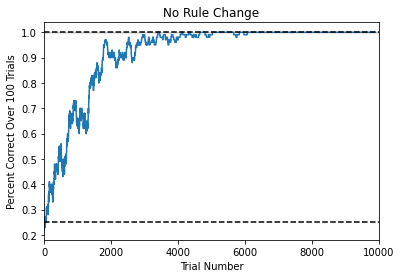

In [4]:
sess = WcstSession(
    trials_to_crit1=None,
    trials_to_crit2=None
)

agent = Naive_Tabular_Agent(epsilon=0, alpha=1, gamma=0, lam=0, num_cards=4)

game_len = 10000
sess, agent, scores = train_agent(sess, agent, game_len)
plot_scores(scores, 100, 1, 0, 'No Rule Change')

This RL agent slowly learns a constant rule.

What about when the rule constantly changes?

100%|██████████| 10000/10000 [00:10<00:00, 999.40it/s]


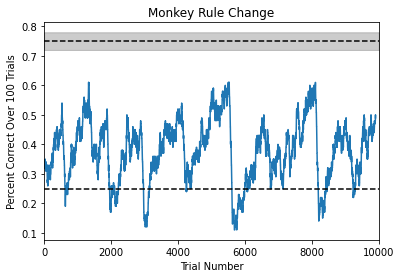

In [5]:
sess = WcstSession()

agent = Naive_Tabular_Agent(epsilon=0, alpha=1, gamma=0, lam=0, num_cards=4)

game_len = 10000
sess, agent, scores = train_agent(sess, agent, game_len)
plot_scores(scores, 100, 0.75, 0.03, 'Monkey Rule Change')

The agent can solve the task, but it is unsurprisingly very far from optimal (top gray band is mean plus std)

What if the agent was "smart" and knew about the features? That is, let's remove the concept of "states" and instead consider 12 actions. Each action will be to choose a particular feature.

Again, choices are greedy, and I use Sarsa with gamma = lambda = 0. I find that tuning alpha to 0.333 improves the accuracy a ton.

100%|██████████| 5000/5000 [00:01<00:00, 2573.88it/s]


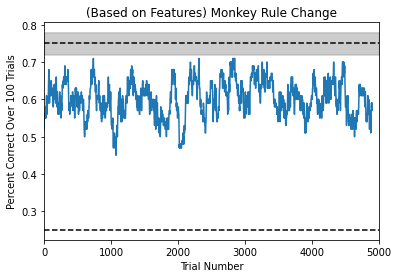

In [6]:
sess = WcstSession()

agent = Feature_Tabular_Agent(epsilon=0, alpha=0.333, gamma=0, lam=0, num_cards=4)

game_len = 5000
sess, agent, scores = train_agent(sess, agent, game_len)
plot_scores(scores, 100, 0.75, 0.03, '(Based on Features) Monkey Rule Change')

Overall, this agent does very well in solving this task. Of course, this is allowing the agent to have knowledge of the rule structure. Later, this will be removed.

# Function Approximation,  Neural Network Method

Above, we were using Sarsa on tabular based methods. What if we use a neural network based function approximation instead? I use the value based Linear Sarsa method with gamma = lambda = 0. Choices are epsilon greedy (epsilon = 0.01).

I'll use a two layer network to find the q value of each action given some state. The set of features are based on which card is observed with the given action:

x(S,A) = length 64 vector (one hot)

By adding a hidden layer of length 12, one gets the function approximation:

q_hat(S,A,w) = (x^T w)^T w2

For TD(lambda), using backwards view (with gamma equal to 0):

1. delta_t = R_(t) - q_hat(S_t,A_t,w)
2. w_(t+1) = w_t + alpha delta_t grad(q_hat(S_t,A_t,w))

I can implement this with SGD and a MSE loss without having to compute any intermediate steps. I use a learning rate (alpha) of 0.1.

100%|██████████| 5000/5000 [00:05<00:00, 983.84it/s] 


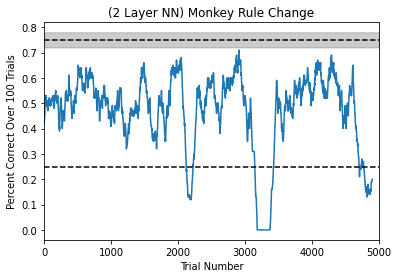

In [7]:
sess = WcstSession()

agent = NN_Agent(epsilon=0.01, alpha=0.1, num_cards=4, num_dims=3)

game_len = 5000
sess, agent, scores = train_agent(sess, agent, game_len)
plot_scores(scores, 100, 0.75, 0.03, '(2 Layer NN) Monkey Rule Change')

The NN does generally well, although it's not as consistent as the feature based tabular method. Of course, this network learns how to choose based on stimuli with no knowledge of features.

The question is, what does this network learn?

To answer this, I train the NN with a constant rule, which allows the weights to converge.

100%|██████████| 1000/1000 [00:01<00:00, 950.35it/s]


Examining the weights, where the correct rule is feature 6


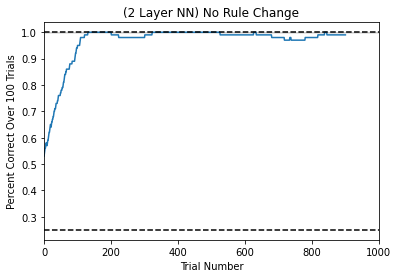

In [8]:
sess = WcstSession(
    trials_to_crit1=None,
    trials_to_crit2=None
)

agent = NN_Agent(epsilon=0.01, alpha=0.1, num_cards=4, num_dims=3)

game_len = 1000
sess, agent, scores = train_agent(sess, agent, game_len)
plot_scores(scores, 100, 1, 0, '(2 Layer NN) No Rule Change')

print('Examining the weights, where the correct rule is feature '+str(sess.current_rule))

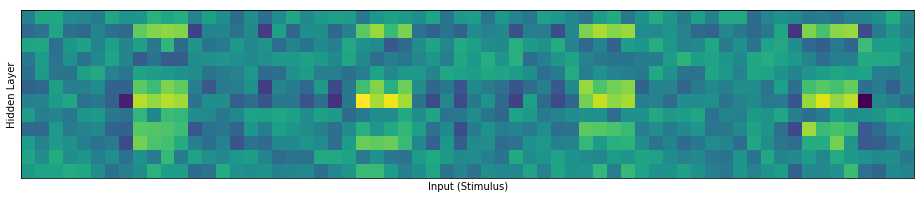

In [17]:
plt.matshow(agent.Q_eval.ih.weight.detach().numpy())
plt.xticks([])
plt.yticks([])
plt.xlabel('Input (Stimulus)')
_ = plt.ylabel('Hidden Layer')

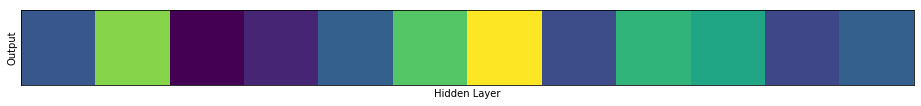

In [18]:
plt.matshow(agent.Q_eval.ho.weight.detach().numpy())
plt.xticks([])
plt.yticks([])
plt.xlabel('Hidden Layer')
_ = plt.ylabel('Output')

This is a little bit confusing because there are two sets of weights. I dot multiply these together to find how each of the 64 stimuli are valued

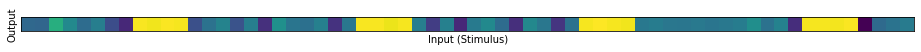

In [22]:
temp = agent.Q_eval.ho.weight.detach().numpy()[:,:,None] * agent.Q_eval.ih.weight.detach().numpy()[None,:,:]
temp = np.sum(temp, axis=1)
plt.matshow(temp)
plt.xticks([])
plt.yticks([])
plt.xlabel('Input (Stimulus)')
_ = plt.ylabel('Output')

The q value is very large for each stimulus where the rule feature (6) is present. This occurs no matter what the rule is. Therefore this neural network learns to adjust the weights towards the value for all stimuli with the rule feature.

# RNN Value Gradient

Thus far, the weights have had to be adjusted after every step. The question is, can an RL agent learn a structure that can generalize across rule changes? That is, if we freeze the weights after learning, will the agent still solve the task?

The best approach is to then learn a recurrent neural network (RNN). With this, the agent will need to learn how to update the hidden (or recurrent) state automatically. There are different ways to structure the RNN, but there are two generic steps:
1. Given some hidden state, what choice should be made
2. Given a hidden state, choice, and reward, how should the hidden state be updated

Ideally, this does not take into account the feature structure. As a starting point, the RNN updates the hidden state without taking into account the feature structure, but the RNN makes a choice using the hidden structure.

That is, the hidden state is of length 12, and the q value for that card is the sum of the three features on that card. To update, the choice (one of 64 cards) is concatenated with the hidden state; this is fed into a linear network to update the hidden state. Since the reward is ambiguous, a different network is used for correct and incorrect choices. This is a natural way to take care of any non-linearity. One could also directly include the reward by multiplying it with the input state.

As found through trial and error, the network has a tendency to focus on the most recent rule, which makes it not generalize too well when the rule changes. As a way to combat this, I introduce a learning schedule: After 200000 trials of learning, the network begins learning every other trial, then every third trial, and so on such that eventually it learns every 500 trials. This way, it can accomodate the rules shifting (and learning when it needs to), but it doesn't lean too heavily on a single rule.

100%|██████████| 1000000/1000000 [11:28<00:00, 1453.00it/s]


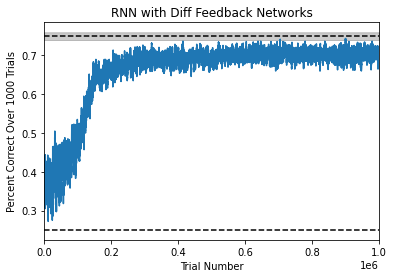

In [26]:
sess = WcstSession()
sess.start_new_session()

agent = RNN_Feature_Agent(
    epsilon=0.01, 
    alpha=0.001, 
    weight_decay=0, 
    num_cards=num_cards,
    num_dims=num_dims,
    separate_fb=True
)

game_len = 1000000
learning_schedule = np.array([i for i in np.arange(500000,1010000,10000)])
learning_rate = np.array(np.logspace(np.log10(2),np.log10(500),len(learning_schedule)-1), dtype=int)
learning_rate = np.insert(learning_rate,0,1)

sess, agent, scores = train_rnn_agent(sess, agent, game_len, learning_rate, learning_schedule, restart_game=False)

plot_scores(scores, 1000, 0.75, 0.01, 'RNN with Diff Feedback Networks')

So this RNN is fairly stable, but does it generalize when no more learning occurs?

Weights are frozen, and the agent keeps performing the task:

100%|██████████| 50000/50000 [00:23<00:00, 2173.16it/s]


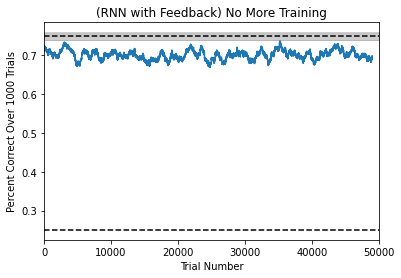

In [27]:
sess = WcstSession()

game_len = 50000

sess, scores = run_rnn_agent(sess, agent, game_len)

plot_scores(scores, 1000, 0.75, 0.01, '(RNN with Feedback) No More Training')

Yes! It generalizes. What do the weights look like?

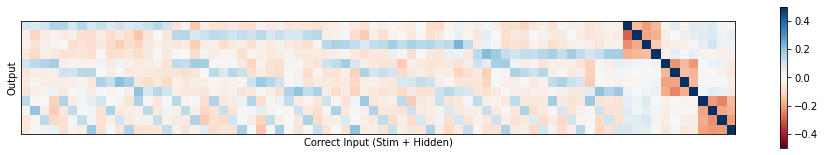

In [28]:
plt.matshow(
    agent.Q_eval.hh_cor.weight.detach().numpy(),
    vmin=-0.5,
    vmax=0.5,
    cmap='RdBu'
)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel('Correct Input (Stim + Hidden)')
_ = plt.ylabel('Output')

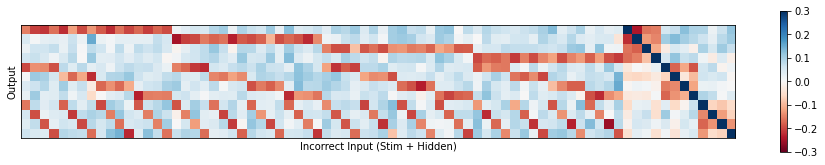

In [29]:
plt.matshow(
    agent.Q_eval.hh_inc.weight.detach().numpy(),
    vmin=-0.3,
    vmax=0.3,
    cmap='RdBu'
)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel('Incorrect Input (Stim + Hidden)')
_ = plt.ylabel('Output')

The y-axis shows the new hidden weights.\
The x-axis shows the input state (first 64 elements) concatenated with the previous hidden weights (last 12)

There are two parts to the weights:
1. The stimulus inputs naturally lead to additions to the new hidden state baased on features. Note that each stimulus has three large weights to the hidden state, and these naturally are explained by the order of the three features.
2. The previous hidden states are retained after each trial. However, notice that the weights in the same dimension are quite low. This has the effect of saying that the current feature should inversely affect features of the same dimension (or do the opposite to the other features compared to the current feature).

Naturally, values are increased for correctly chosen features and decreased for incorrectly chosen features.

Thus far, this RNN takes advantage of the feature aspect. The question remains, can the RNN learn from stimuli directly. That is, with no inherent structure about features, what the agent learn?

The RNN structure is similar to before, but now the hidden state remembers something about the 64 cards instead of the 12 features.

In [5]:
sess = WcstSession()
sess.start_new_session()

agent = RNN_Stimulus_Agent(epsilon=0.01, alpha=0.001, weight_decay=0, num_cards=num_cards, num_dims=num_dims)

game_len = 10000000

learning_schedule = np.array([10000001])
learning_rate = np.array([1], dtype=int)

sess, agent, scores = train_rnn_agent(sess, agent, game_len, learning_rate, learning_schedule, restart_game=True)

100%|██████████| 10000000/10000000 [2:55:45<00:00, 948.29it/s] 


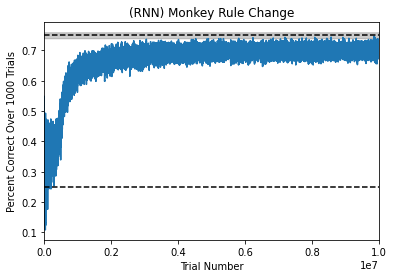

In [6]:
plot_scores(scores, 1000, 0.75, 0.01, '(RNN) Monkey Rule Change')

Through a ton of training, the agent learns the task and eventually reaches a score close to optimal (70.5%). While not optimal, this is on par with human behavior. Again, what do the weights look like?

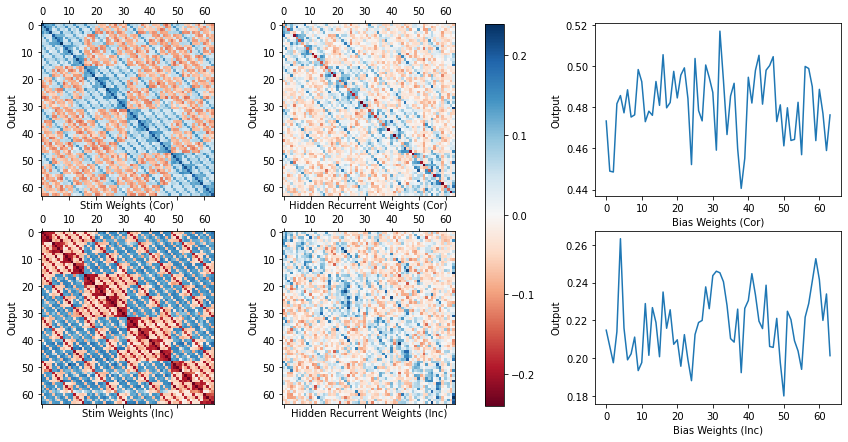

In [304]:
fig, ax = plt.subplots(2, 3, figsize=(15,7))

lim=0.24
im = ax[0,0].matshow(
    agent.Q_eval.hh_cor.weight.detach().numpy()[:,:64],
    cmap='RdBu',
    vmin=-lim,
    vmax=lim
)
ax[0,0].set_xlabel('Stim Weights (Cor)')

ax[0,1].matshow(
    agent.Q_eval.hh_cor.weight.detach().numpy()[:,64:],
    cmap='RdBu',
    vmin=-lim,
    vmax=lim
)
ax[0,1].set_xlabel('Hidden Recurrent Weights (Cor)')

ax[0,2].plot(agent.Q_eval.hh_cor.bias.detach().numpy())
ax[0,2].set_xlabel('Bias Weights (Cor)')


ax[1,0].matshow(
    agent.Q_eval.hh_inc.weight.detach().numpy()[:,:64],
    cmap='RdBu',
    vmin=-lim,
    vmax=lim
)
ax[1,0].set_xlabel('Stim Weights (Inc)')

ax[1,1].matshow(
    agent.Q_eval.hh_inc.weight.detach().numpy()[:,64:],
    cmap='RdBu',
    vmin=-lim,
    vmax=lim
)
ax[1,1].set_xlabel('Hidden Recurrent Weights (Inc)')

ax[1,2].plot(agent.Q_eval.hh_inc.bias.detach().numpy())
ax[1,2].set_xlabel('Bias Weights (Inc)')

for i in range(2):
    for j in range(3):
        ax[i,j].set_ylabel('Output')
        
for i in range(2):
    box = ax[i,1].get_position()
    box.x0 = box.x0 - 0.05
    box.x1 = box.x1 - 0.05
    ax[i,1].set_position(box)
    
cb_ax = fig.add_axes([0.47, 0.1, 0.118, 0.8])
fig.colorbar(im, ax=cb_ax)
cb_ax.set_axis_off()

Interestingly, looking at the weights for the choice (left plots), there is evidence for feature representations. Basically, the hidden value of the exact stimuli chosen is boosted the most (darkest blue, diagonal). Then, cards with 2 of the same features are boosted the second most (dark blue). Cards with a single overlapping feature are boosted a little (light blue). And, cards with completely different features are negatively boosted (red).

To visualize this information, I'll plot these values in a 3 dimensional space. Essentially, every column in the above plot (where the column is how some choice leads to some output) is transformed into the 3d space locations. E.g. color is one dimension, shape is another, and pattern is the last dimension. So, as an example, let's plot the first column of the stim weights (upper left) in this three dimensional plot.

In [2]:
# Saved
# np.save('scores.npy', np.array(scores_all))
# np.save('hh_cor_weights.npy', agent.Q_eval.hh_cor.weight.detach().numpy())
# np.save('hh_inc_weights.npy', agent.Q_eval.hh_inc.weight.detach().numpy())
# np.save('hh_cor_bias.npy', agent.Q_eval.hh_cor.bias.detach().numpy())
# np.save('hh_inc_bias.npy', agent.Q_eval.hh_inc.bias.detach().numpy())

# Loaded
stim_cor = np.load('hh_cor_weights.npy')
hidd_cor = stim_cor[:,64:]
stim_cor = stim_cor[:,:64]
stim_inc = np.load('hh_inc_weights.npy')
hidd_inc = stim_inc[:,64:]
stim_inc = stim_inc[:,:64]

# Use this directly from weights
# stim_cor = agent.Q_eval.hh_cor.weight.detach().numpy()
# hidd_cor = stim_cor[:,64:]
# stim_cor = stim_cor[:,:64]
# stim_inc = agent.Q_eval.hh_inc.weight.detach().numpy()
# hidd_inc = stim_inc[:,64:]
# stim_inc = stim_inc[:,:64]

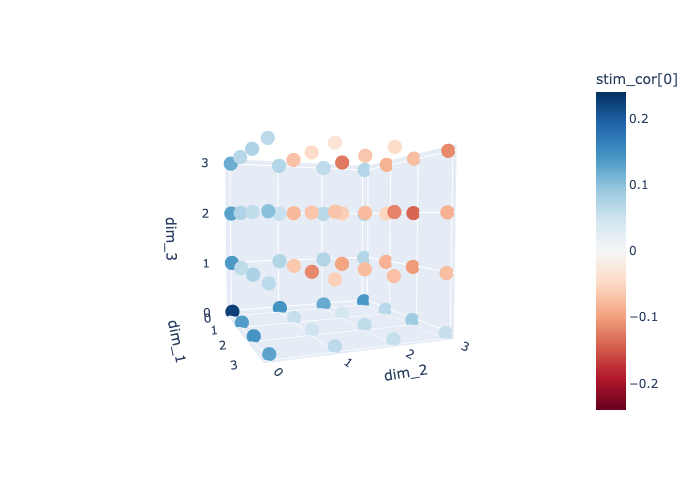

In [3]:
plot_stim_by_dim(stim_cor[0], 'stim_cor[0]')

Basically, for this choice of card [0,0,0], the resulting output is large for card [0,0,0], smaller for cards with two features in the same dimesion, smaller for one feature in the same dimension, and negative when all features are in different dimensions.

For column number 2 (1 with zero index), we get the following:

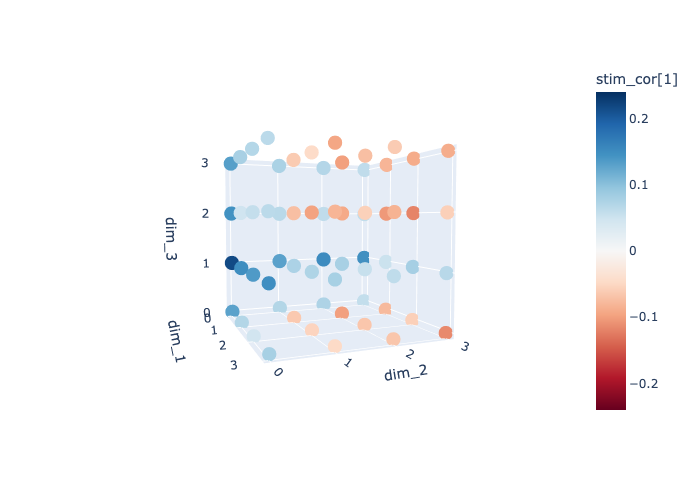

In [4]:
plot_stim_by_dim(stim_cor[1], 'stim_cor[1]')

To average across all columns simultaneously, the locations in this space need to be consistent. For example, location "1" in dim_3 should be moved downward to location "0" before averaging with the other columns. This would look like the following:

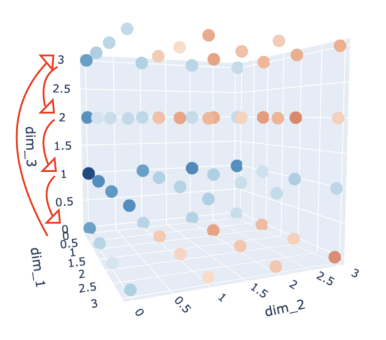

In [5]:
image = mpimg.imread("Figures/rolling.png")
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.imshow(image)
_ = ax.axis("off")

This is done for all 64 columns in the earlier figure. Then, the data is averaged for every point in this space

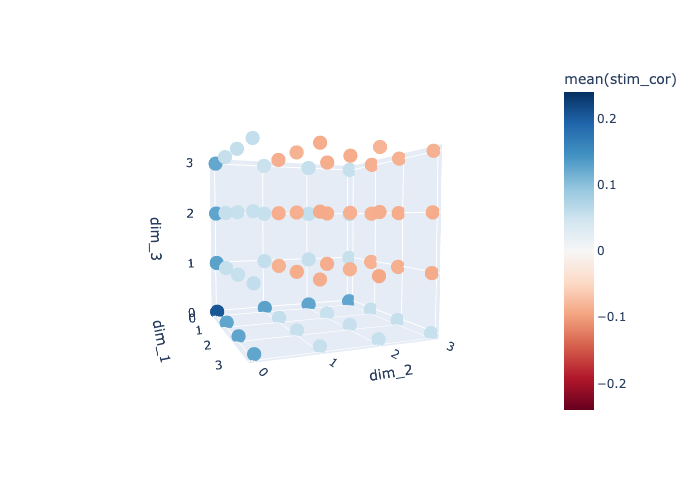

In [6]:
plot_stim_by_dim(average_stim(stim_cor), 'mean(stim_cor)')

Interpretation: If correct, all card values are modified based on the number of shared features with the chosen card. The change in value is determined via the number of shared features. The value is decreased only when no features are shared.

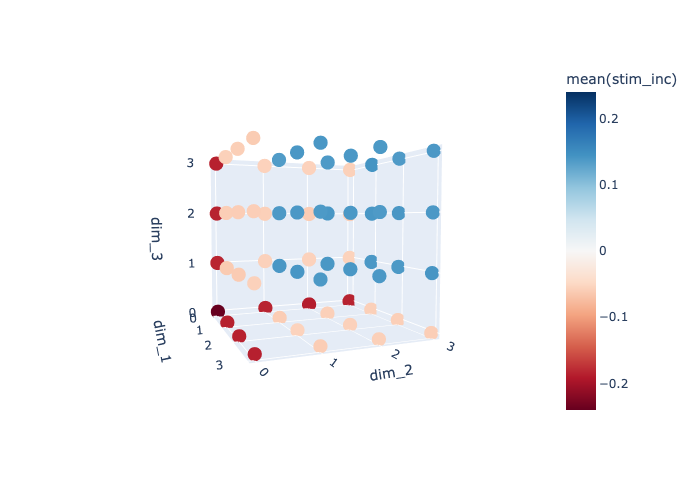

In [7]:
plot_stim_by_dim(average_stim(stim_inc), 'mean(stim_inc)')

Interpretation: If incorrect, all card values are modified based on the number of shared features with the chosen card. The change in value is determined via the number of shared features. The value is increased only when no features are shared.

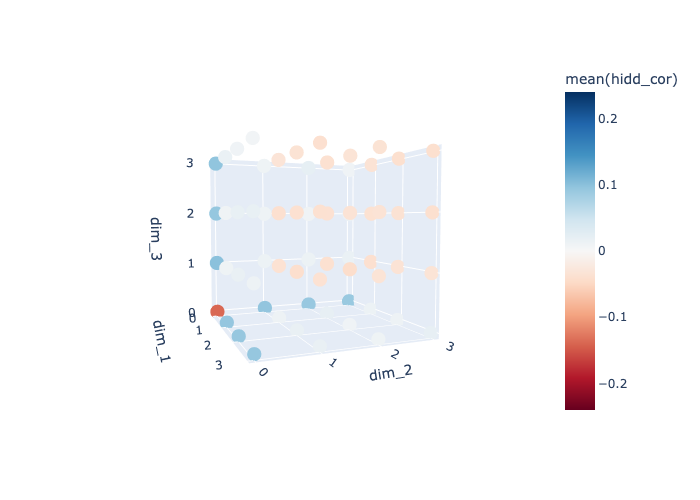

In [8]:
plot_stim_by_dim(average_stim(hidd_cor), 'mean(hidd_cor)')

Interpretation: If correct, decrease the value of the card of interest. Increase the value of cards sharing one feature. Decrease the value of cards sharing no features.

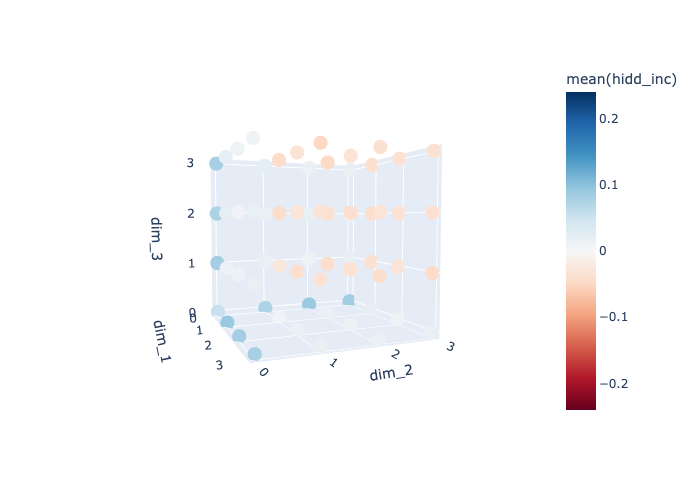

In [9]:
plot_stim_by_dim(average_stim(hidd_inc), 'mean(hidd_inc)')

Interpretation: If incorrect, increase the value of the card of interest. Increase the value of cards sharing one feature. Decrease the value of cards sharing no features. This is extremely similar to the correct case, with the difference in the card of interest.

Overall, it's interesting that there is structure in the hidden state update. This allows for information about values for one card to be spread to other cards. This is something that cannot be accomplished with table based methods, since values are only updated based on the choice. That would be akin to an update of zero in these plots everywhere except [0,0,0].

# Conclusions

Overall, using the RL framework, we found a ton of interesting things about this task. I list the findings below as a summary to the above results:

- RNN's are able to learn the structure of the task: The weights can be frozen, and the agent will still perform the task well.
- RNN's can find task structure with NO knowledge of the importance of features. That is, it can learn only information about the chosen stimuli. While taking longer to train, information about one card spreads to all other cards in a way that resembles learning of features.
- The best agent (thus far) uses a different network of weights for correct and incorrect trials, showing slight differences in how values are updated.
- The best agent (thus far) performs close to the optimal agent. In general, it performs at the level of a human participant (not shown, but stay tuned for the afforementioned publication on monkeys and humans performing this task!).
- The RNN agent learns to update the hidden values on every trial based on chosen cards (in a feature based way), and it spreads information from each hidden value to all other hidden values. In this way, information can be broadened to all stimuli.

That being said, this analysis leaves room for future improvements:
- What needs to be added for the agent to perform at the optimal level?
- Perhaps knowledge of time can be added in, where the agent performs differently based on the number of consecutive correct/incorrect trials in a row.
- Perhaps more specific agents should be used, such as actor-critic agents.